
[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
['ETHBTC', 'LTCBTC', 'BNBBTC', 'NEOBTC', 'QTUMETH', 'EOSETH', 'SNTETH', 'BNTETH', 'BCCBTC', 'GASBTC', 'BNBETH', 'BTCUSDT', 'ETHUSDT', 'HSRBTC', 'OAXETH', 'DNTETH', 'MCOETH', 'ICNETH', 'MCOBTC', 'WTCBTC', 'WTCETH', 'LRCBTC', 'LRCETH', 'QTUMBTC', 'YOYOBTC', 'OMGBTC', 'OMGETH', 'ZRXBTC', 'ZRXETH', 'STRATBTC', 'STRATETH', 'SNGLSBTC', 'SNGLSETH', 'BQXBTC', 'BQXETH', 'KNCBTC', 'KNCETH', 'FUNBTC', 'FUNETH', 'SNMBTC', 'SNMETH', 'NEOETH', 'IOTABTC', 'IOTAETH', 'LINKBTC', 'LINKETH', 'XVGBTC', 'XVGETH', 'SALTBTC', 'SALTETH', 'MDABTC', 'MDAETH', 'MTLBTC', 'MTLETH', 'SUBBTC', 'SUBETH', 'EOSBTC', 'SNTBTC', 'ETCETH', 'ETCBTC', 'MTHBTC', 'MTHETH', 'ENGBTC', 'ENGETH', 'DNTBTC', 'ZECBTC', 'ZECETH', 'BNTBTC', 'ASTBTC', 'ASTETH', 'DASHBTC', 'DASHETH', 'OAXBTC', 'ICNBTC', 'BTGBTC', 'BTGETH', 'EVXBTC', 'EVXETH', 'REQBTC', 'REQETH', 'VIBBTC', 'VIBETH', 'HSRETH', 'TRXBTC', 'TRXETH', 'POWRBTC', 'POW

Tickers:   0%|          | 0/1 [00:00<?, ?it/s]

monthly files to download:   0%|          | 0/1 [00:00<?, ?files/s]

daily files to download: 0files [00:00, ?files/s]

Mean Absolute Error for Open: 3.542045167986639e-13
Mean Absolute Error for High: 8.662094479112055e-13
Mean Absolute Error for Low: 8.57909140967899e-13
Mean Absolute Error for Close: 5.397569701383252e-13
Mean Absolute Error for SMA_256: 8.735925372994355e-19
Mean Absolute Error for SMA_512: 1.3244273082872025e-18
Mean Absolute Error for SMA_1024: 1.802668530215252e-18
Average MAE: 3.7401201092920986e-13


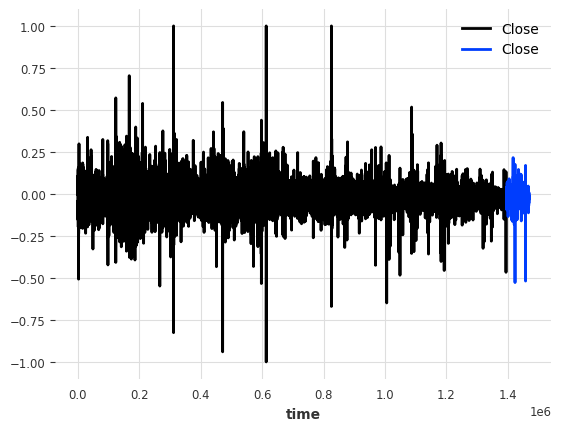

In [12]:
!pip install binance_historical_data mplfinance darts
from binance_historical_data import BinanceDataDumper

data_dumper = BinanceDataDumper(
    path_dir_where_to_dump=".",
    asset_class="spot",  # spot, um, cm
    data_type="klines",  # aggTrades, klines, trades
    data_frequency="1m",
)

print(data_dumper.get_list_all_trading_pairs())

data_dumper.dump_data(tickers=["NEARUSDT"])
import pandas as pd
import numpy as np
import os

filenames = next(os.walk("./spot/monthly/klines/NEARUSDT/1m"), (None, None, []))[2]  # [] if no file

columns = [
    "Open time",
    "Open",
    "High",
    "Low",
    "Close",
    "Volume",
    "Close time",
    "Quote asset volume",
    "Number of trades",
    "Taker buy base asset volume",
    "Taker buy quote asset volume",
    "Ignore"
]

df = pd.DataFrame(columns=columns)

for f in filenames:
    new_df = pd.read_csv(f"./spot/monthly/klines/NEARUSDT/1m/{f}", header=None, names=columns)
    df = pd.concat([df, new_df])
df = df.sort_values(by="Open time")

OHLC_COLUMNS = [
    "Open",
    "High",
    "Low",
    "Close"]
dataset = df.loc[:, OHLC_COLUMNS].astype(np.float64)
dataset = pd.DataFrame(dataset.to_numpy(), columns=OHLC_COLUMNS)


def add_features(df):
    df = df.copy()
    # add technical indicators to dataset
    df['SMA_256'] = df['Close'].rolling(window=256).mean()
    df['SMA_512'] = df['Close'].rolling(window=512).mean()
    df['SMA_1024'] = df['Close'].rolling(window=1024).mean()

    # convert SMA columns to distance in percentages from "Close"
    df['SMA_256'] = ((df['Close'] - df['SMA_256']) / df['SMA_256'])
    df['SMA_512'] = ((df['Close'] - df['SMA_512']) / df['SMA_512'])
    df['SMA_1024'] = ((df['Close'] - df['SMA_1024']) / df['SMA_1024'])

    # drop NaN rows resulting from the SMA calculations
    df = df.dropna()
    return df


dataset = add_features(dataset)

from sklearn.preprocessing import MinMaxScaler, StandardScaler


class MultiScaler:
    def __init__(self, min_max: MinMaxScaler, std: StandardScaler):
        self.min_max = min_max
        self.std = std


def preprocess(df, scaler=None):
    # Apply percentage change only to OHLC columns
    df_pct = df[OHLC_COLUMNS].pct_change()

    # clamp
    df_pct[df_pct > 0.1] = 0.1
    df_pct[df_pct < -0.1] = -0.1

    # Concatenate the percentage-changed OHLC with the other columns
    df_all = pd.concat([df_pct, df.drop(columns=OHLC_COLUMNS)], axis=1)

    # Drop NA values (from pct_change operation)
    df_all = df_all.dropna()

    # Apply MinMax scaling to all columns
    if scaler is None:
        scaler = MultiScaler(MinMaxScaler(feature_range=(-1, 1)), StandardScaler())
        df_multi_scaled = scaler.min_max.fit_transform(scaler.std.fit_transform(df_all))
    else:
        df_multi_scaled = scaler.min_max.transform(scaler.std.transform(df_all))

    df_scaled = pd.DataFrame(df_multi_scaled,
                             columns=df_all.columns,
                             index=df_all.index)

    return df_scaled, scaler


def invert_preprocess(original_start, scaler: MultiScaler, df):
    original_start = original_start[OHLC_COLUMNS].to_numpy()
    # Invert MinMax scaling for all columns
    df_inv_scaled = pd.DataFrame(scaler.std.inverse_transform(scaler.min_max.inverse_transform(df)),
                                 columns=df.columns,
                                 index=df.index)

    # Recover the original OHLC values
    reversed_array = np.cumprod(1 + df_inv_scaled[OHLC_COLUMNS].to_numpy(), axis=0)
    reversed_array = reversed_array * original_start  # Scaling by the original_start to each element

    df_inv_scaled[OHLC_COLUMNS] = reversed_array

    return df_inv_scaled


preprocessed_dataset, scaler = preprocess(dataset)

# transform dataset so that all transform-invert transform pairs are idempotent
dataset = invert_preprocess(dataset.iloc[0], scaler, preprocessed_dataset)
dataset = add_features(dataset)

from sklearn.metrics import mean_absolute_error


def test_preprocess_invert_preprocess(original_df):
    original_df = original_df
    preprocessed_df, scaler = preprocess(original_df)

    # Assume that 'original_start' is the first row of the original DataFrame
    original_start = original_df.iloc[0]

    inverted_df = invert_preprocess(original_start, scaler, preprocessed_df)

    mae_list = []
    for col in original_df.columns:
        # Start from the second row of the original_df for comparison
        mae = mean_absolute_error(original_df.iloc[1:][col], inverted_df[col])
        mae_list.append(mae)
        print(f"Mean Absolute Error for {col}: {mae}")

    avg_mae = sum(mae_list) / len(mae_list)
    print(f"Average MAE: {avg_mae}")

    return avg_mae < 1e-9


# Assuming 'dataset' is your original DataFrame
assert test_preprocess_invert_preprocess(dataset)


def test_orig_val():
    # The original_start passed to invert_preprocess() must be the first value in the corresponding
    # original DataFrame segment. For the first range, that's range_orig.iloc[0].
    # For the second range, it's range_orig.iloc[500].

    range_orig = dataset.iloc[1000:2000]
    range_preproc, s = preprocess(range_orig)

    # Inverted for the whole preprocessed range
    range1_inv = invert_preprocess(range_orig.iloc[0], s, range_preproc)

    # Inverted for the latter part of the preprocessed range
    range2_inv = invert_preprocess(range_orig.iloc[500], s, range_preproc.iloc[500:])

    # Due to floating point errors, equality may not be exact. So you might use pd.testing.assert_frame_equal
    # with the check_exact=False parameter
    pd.testing.assert_frame_equal(range1_inv.iloc[500:].reset_index(drop=True),
                                  range2_inv.reset_index(drop=True), check_exact=False)


test_orig_val()
import numpy as np
import pandas as pd

from darts import TimeSeries
from darts.models import RNNModel

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

target_series = TimeSeries.from_dataframe(preprocessed_dataset)
target_train, target_val = target_series.split_after(0.95)

target_train["Close"].plot()
target_val["Close"].plot()
from darts.models import TFTModel

SEQUENCE_LENGTH = 128
PREDICTION_LENGTH = 32

my_model = TFTModel.load("model-weights-1694092035.1712623.pt")

In [69]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover, SignalStrategy, TrailingStrategy

from backtesting.test import SMA


class NeuralNetStrat(Strategy):
    def __init__(self, broker, data, params):
        super().__init__(broker, data, params)
        self.buy_price = None
        self.expected_gain = None

    def init(self):
        pass

    def next(self):
        if len(self.data) > 2000:
            df = self.data.df.iloc[-2000:].copy()
            df.drop(columns=["Volume"], inplace=True)
            df_with_features = add_features(df)

            original_start = df_with_features.iloc[-1]

            df_preprocessed, _ = preprocess(df_with_features, scaler)

            X = TimeSeries.from_dataframe(df_preprocessed[-SEQUENCE_LENGTH:])
            y = my_model.predict(PREDICTION_LENGTH, X, verbose=False)

            y_inverted = invert_preprocess(original_start, scaler, y.pd_dataframe())
            y_max_close = y_inverted.Close.mean()
            curr_close = original_start.Close

            gain = (y_max_close - curr_close) / curr_close

            if self.buy_price is None:
                if gain > 0.01:
                    self.buy()
                    self.buy_price = curr_close
                    self.expected_gain = gain
            else:
                gain_from_trade = (curr_close - self.buy_price) / self.buy_price
                if -0.008 > gain_from_trade or gain_from_trade > 0.008:
                    self.sell()
                    self.buy_price = None
                    self.expected_gain = None
                    print(f"gained {gain_from_trade}")


bt = Backtest(dataset[:], NeuralNetStrat, commission=.001,
              exclusive_orders=True)
stats = bt.run()
stats

gained -0.013067581837381236
gained 0.01103542234332425
gained 0.00950413223140514
gained -0.011433238056349639
gained 0.012722298221614203
gained 0.009620523784072674
gained -0.00978447705936793
gained 0.011339381003201351
gained -0.009606527174628211
gained 0.009966777408637965
gained 0.008777675881043044
gained -0.010589619558112176
gained 0.012771052281494617
gained 0.010132912225292867
gained 0.011617282339120258
gained 0.008803266139321003
gained 0.008029569207239616
gained -0.009399674144629463
gained 0.020037570444583777
gained -0.008534850640113919
gained 0.010588235294117539
gained 0.01413594062904926
gained -0.010378582379997564
gained -0.00879765395894424
gained 0.008896797153025002
gained -0.012691258450954753
gained -0.009265944645006217
gained 0.008183705875168151
gained 0.010037489418309339
gained -0.008466376390904319
gained 0.009697873927639131
gained -0.01000488042947779
gained -0.008934035001836147
gained -0.009225092250922055
gained 0.011975308641975784
gained 0.01

TypeError: 'NoneType' object is not iterable